In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import mne

from data_analysis.functions_graph_theory import \
    weighted_small_world_coeff
from data_analysis.functions_connectivity import \
    full_ispc
from data_analysis.functions_preprocessing import \
    (combine_raws, split_raws, preprocess_single_sub, mark_bads_and_save,
     run_ica_and_save)

subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'

%matplotlib notebook


Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
subj_pair = 208

subj_ids = ["sub-{0}_p-{1}".format(subj_pair, s) for s in range(2)]

subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)


In [3]:
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)
raws = list(split_raws(combined_raw))
del combined_raw
print(raws)

for ind, raw in enumerate(raws):
    raws[ind].set_eeg_reference(["Cz"])
    montage = mne.channels.make_standard_montage("standard_1005")
    raws[ind].set_montage(montage)
    raws[ind].filter(l_freq = 0.1, h_freq = 120)
    raws[ind].notch_filter(freqs=[16.666666667, 50])
    
    raws[ind] = mne.preprocessing.compute_current_source_density(raws[ind])
    
raw_combined = combine_raws(raws[0], raws[1])
del raws


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-208/eeg/sub-208_task-hyper_eeg.fif...


<ipython-input-3-0be97828718d>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-208/eeg/sub-208_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-208/eeg/sub-208_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 4035781 =   3638.000 ...  3941.192 secs
Ready.
Reading 0 ... 4035781  =      0.000 ...  3941.192 secs...
[<Raw | sub-208_task-hyper_eeg.fif, 80 x 4035782 (3941.2 s), ~2.41 GB, data loaded>, <Raw | sub-208_task-hyper_eeg.fif, 80 x 4035782 (3941.2 s), ~2.41 GB, data loaded>]
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0

In [5]:
import numpy as np
import scipy

events = mne.find_events(raw_combined, stim_channel="STI 014")

event_id = 6
tmin = 0
tmax = 10

epochs = mne.Epochs(raw_combined, events, event_id, tmin, tmax,
                    picks=["csd"], baseline=(0, 0))

tfrs = []
pas = []
for ind, epoch in enumerate(epochs):
    
    sfreq = epochs.info["sfreq"]
    freqs, times, signal_stft = scipy.signal.stft(epoch, fs=sfreq, axis=-1,
                                                  nperseg=32)
    phase_angles = np.angle(signal_stft)
    
    tfrs.append(signal_stft)
    pas.append(phase_angles)

6650 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
300 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [13]:
from mne.time_frequency import AverageTFR
from data_analysis.functions_preprocessing import COMMON_CH_SET

raw_combined.pick(["all"], exclude=COMMON_CH_SET)
info = raw_combined.info
del raw_combined

tfr_avg = np.sum(np.array(tfrs), axis=0)
pas_avg = np.sum(np.array(pas), axis=0)
del tfrs; del pas

stft_TFR = AverageTFR(info=info, data=tfr_avg,
                    times=times, freqs=freqs, nave=len(tfrs))

angles_TFR = AverageTFR(info=info, data=pas_avg,
                    times=times, freqs=freqs, nave=len(pas))

NameError: name 'raw_combined' is not defined

In [20]:
stft_TFR = AverageTFR(info=info, data=np.abs(tfr_avg),
                    times=times, freqs=freqs, nave=ind)

angles_TFR = AverageTFR(info=info, data=pas_avg,
                    times=times, freqs=freqs, nave=ind)


No baseline correction applied


<IPython.core.display.Javascript object>


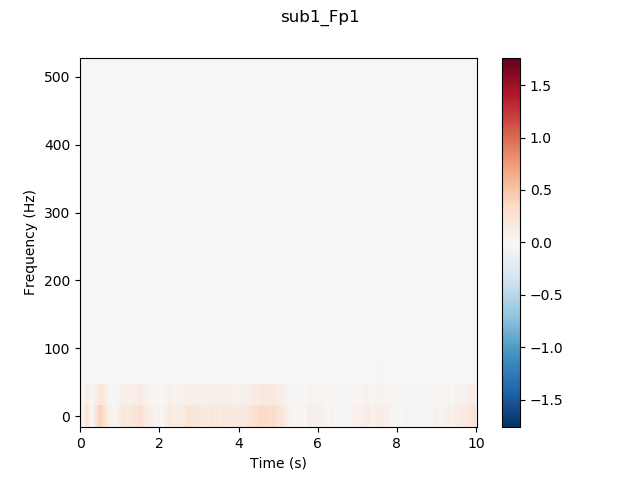

<IPython.core.display.Javascript object>


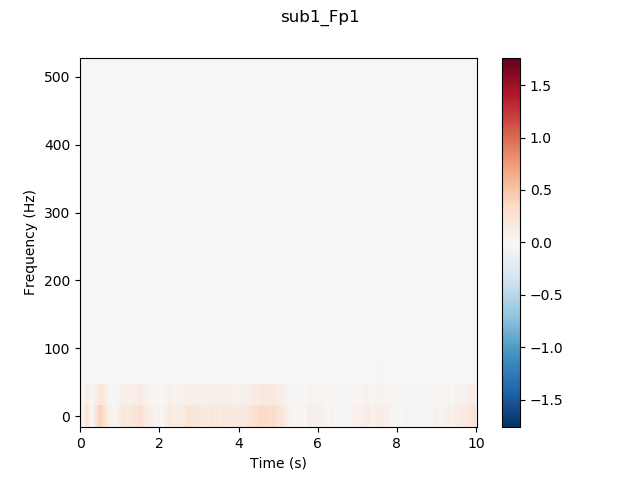

In [23]:
stft_TFR.plot(picks=["all"])

In [24]:
!cd /net/store/nbp/projects/hyperscanning/study_project
!chown -hR $USER:nbp *; chmod -R 770 *